 # Generating Dog Images with a Deep Convolutional Generative Adverserial Network

This kernel attempts be an all in one guide with some of my own writing and also links to great references. Contribution to this kernel is iterative as the competition progresses.

Let us start with a non-technical example of what a GAN is
inspired by this [article](https://skymind.ai/wiki/generative-adversarial-network-gan). 

Suppose there is a currency counterfeiter named George and a detective named Derek. George,
for some reason has never seen real currency notes but wishes to make counterfeits in 
hopes of becoming rich. He makes what he thinks is a dollar bill and transports it to detective
Derek through a network of people. Derek looks at real currency that he has in his pocket
and at the currency he received from George and easily knows this is fake and looks like 
money from the Monopoly boardgame. 

For some odd reason Derek also associates these numerical values
to the real currency and the fake currency. Initially the real currency has high values associated with them and fake one has low. He also chooses to share the value for fake currency with a colleague. This colleague however is working with George and shares this information so George can improve. So George makes some changes and again has the bills transported to Derek. Some value is shared with Derek's colleague which is carried over to George. 

Thus this cycle continues with a primary goal of George trying to trick Derek and Derek tyring to determine between real and fake. George is the generator, Derek is the discriminator and they are adversaries. 

Check out this [kernel](https://www.kaggle.com/jesucristo/gan-introduction) for a more detailed introduction. 

# Import Necessary Libraries

In [1]:
# imports ...
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf # ml framework
tf.enable_eager_execution() # operations are executed immediately as they are called from Python
import numpy as np # linear algebra
import warnings
from PIL import Image # image processing library
import IPython.display as display # for inspecting the images by displaying them in the kernel
import random # for the random seed used as input for the generator
import matplotlib.pyplot as plt, zipfile # plotting library
import xml.etree.ElementTree as ET # xml parser used during pre-processing stage
import time # time the execution of codeblocks
import xml.dom.minidom # for printing the annotation xml nicely

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os, glob # for managing files/directories
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['all-dogs', 'annotation']


In [2]:
tf.__version__

'1.14.0'

# Get images and pre-process

In [3]:
# Demo: Show how the Annotation files XML is structured
dom = xml.dom.minidom.parse('../input/annotation/Annotation/n02097658-silky_terrier/n02097658_98') 
pretty_xml_as_string = dom.toprettyxml()
print(pretty_xml_as_string)

<?xml version="1.0" ?>
<annotation>
	
	
	<folder>02097658</folder>
	
	
	<filename>n02097658_98</filename>
	
	
	<source>
		
		
		<database>ImageNet database</database>
		
	
	</source>
	
	
	<size>
		
		
		<width>500</width>
		
		
		<height>400</height>
		
		
		<depth>3</depth>
		
	
	</size>
	
	
	<segment>0</segment>
	
	
	<object>
		
		
		<name>silky_terrier</name>
		
		
		<pose>Unspecified</pose>
		
		
		<truncated>0</truncated>
		
		
		<difficult>0</difficult>
		
		
		<bndbox>
			
			
			<xmin>93</xmin>
			
			
			<ymin>117</ymin>
			
			
			<xmax>269</xmax>
			
			
			<ymax>289</ymax>
			
		
		</bndbox>
		
	
	</object>
	
	
	<object>
		
		
		<name>silky_terrier</name>
		
		
		<pose>Unspecified</pose>
		
		
		<truncated>0</truncated>
		
		
		<difficult>0</difficult>
		
		
		<bndbox>
			
			
			<xmin>290</xmin>
			
			
			<ymin>104</ymin>
			
			
			<xmax>393</xmax>
			
			
			<ymax>244</ymax>
			
		
		</bndbox>
		
	
	</object>
	

</annotation>



Thanks to Chris Deotte for the following snippet and Paulo Pinto for posting code on retrieving bounding boxes.

In [4]:
# Code slightly modified from user: cdeotte | https://www.kaggle.com/cdeotte/supervised-generative-dog-net

ROOT = '../input/'
# list of all image file names in all-dogs
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs')
# list of all the annotation directories, each directory is a dog breed
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# iterate through each directory in annotation
for breed in breeds:
    # iterate through each file in the directory
    for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
        try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
        except: continue           
        # Element Tree library allows for parsing xml and getting specific tag values    
        tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
        # take a look at the print out of an xml previously to get what is going on
        root = tree.getroot() # <annotation>
        objects = root.findall('object') # <object>
        for o in objects:
            bndbox = o.find('bndbox') # <bndbox>
            xmin = int(bndbox.find('xmin').text) # <xmin>
            ymin = int(bndbox.find('ymin').text) # <ymin>
            xmax = int(bndbox.find('xmax').text) # <xmax>
            ymax = int(bndbox.find('ymax').text) # <ymax>
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((64,64), Image.ANTIALIAS)
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            namesIn.append(breed)
            idxIn += 1                

In [5]:
# Inspect what the previous code created
print("imagesIn is a {} with {} {} by {} rgb({}) images. Shape: {}".format(type(imagesIn), imagesIn.shape[0], imagesIn.shape[1], imagesIn.shape[2], imagesIn.shape[3], imagesIn.shape))

imagesIn is a <class 'numpy.ndarray'> with 25000 64 by 64 rgb(3) images. Shape: (25000, 64, 64, 3)


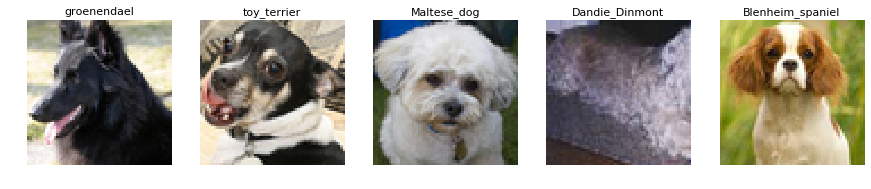

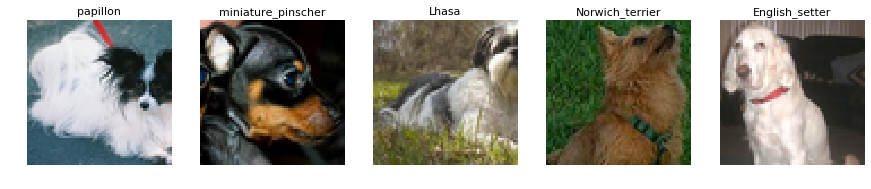

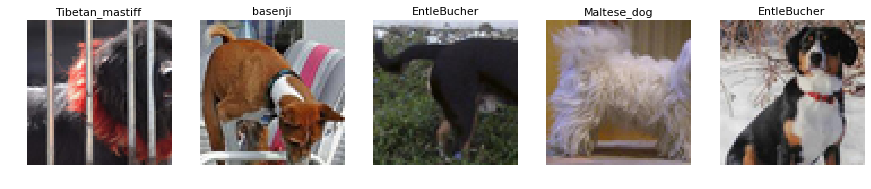

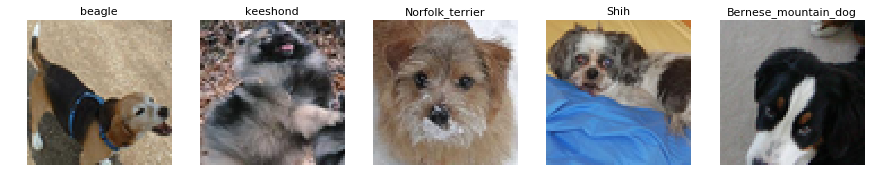

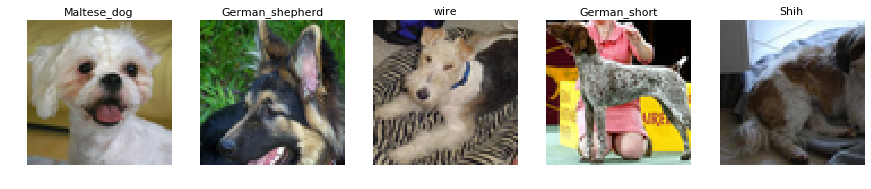

In [6]:
# DISPLAY CROPPED IMAGES

# list of 25 random numbers in range 0, idxIn
# this allows for displaying random images in the for loop using x[k*5+j]
x = np.random.randint(0,idxIn,25)

for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [7]:
# normalize the pixel values
imagesIn = (imagesIn[:idxIn,:,:,:]-127.5)/127.5

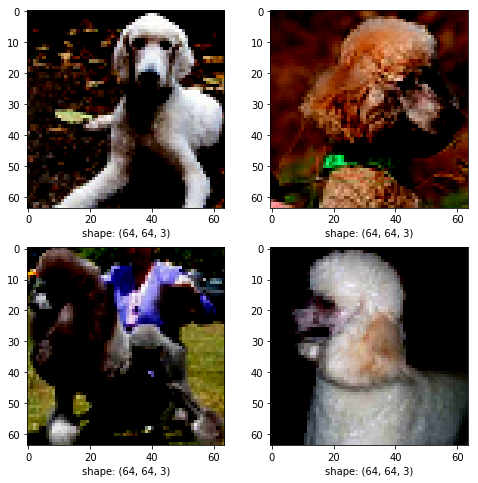

In [8]:
# view some images in the after normalization 
plt.figure(figsize=(8,8))
for image in range(4):
    plt.subplot(2,2, image+1)
    plt.imshow((imagesIn[image]))
    plt.xlabel('shape: {}'.format(imagesIn[image].shape))


**Create Dataset**

In [9]:
# this is needed because the gradient functions from TF require float32 instead of float64
imagesIn = tf.cast(imagesIn, 'float32')

The batch sizes will be a "hyperparameter" to experiment with for better performance.

In [10]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)

<DatasetV1Adapter shapes: (?, 64, 64, 3), types: tf.float32>


# Generator Model

Similar to this image is what the Generator network is doing
![](https://cdn-images-1.medium.com/max/1043/1*KvMnRfb76DponICrHIbSdg.png)


In [11]:
# weight initializers for the Generator network
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0

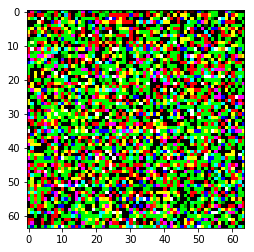

In [12]:
# the generator CNN
dim = 64
def make_generator():
    model = tf.keras.Sequential(
        [
            # first layer with 32,768 nodes expecting an input of vector size 100 (random noise)
            tf.keras.layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
            # Normalize the activations of the previous layer at each batch
            tf.keras.layers.BatchNormalization(),
            # apply leaky relu activation: f(x) = {x if x > 0 : 0.01*x}
            tf.keras.layers.LeakyReLU(),
            # reshape input to (8,8,512)
            tf.keras.layers.Reshape((8, 8, 512)),
            
            # second layer Conv2DTranspose so it is doing the opposite of a convolutional layer
            tf.keras.layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Dense(3,activation='tanh', use_bias=False,\
                kernel_initializer=WEIGHT_INIT)
        ]
    )
    return model
# create an instance of the generator model defined
generator = make_generator()
print(generator.summary())
# random noise vector
noise = tf.random.normal([1,100])
# run the generator model with the noise vector as input
generated_image = generator(noise, training=False)
# display output
plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)

# Discriminator model

The discriminator is a regular CNN which will be used for real dog pictures from training data and fake ones generated by the generator. I am initializing weights in the first layer with standard deviation = WEIGHT_INIT_STDDEV which will be changing while optimizing for better performance. 

In [13]:
def make_discriminator():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=[dim,dim,3],\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same',\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same',\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            # flatten input into 1-D and output a single a number from the last layer using tanh activation
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='linear')
        ]
    )
    return model

discriminator = make_discriminator()
print(discriminator.summary())
decision = discriminator(generated_image)
print (decision)
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)      

# Loss and optimizers

Information on [AdamOptimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) and for [Binary Cross Entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a). 

BCE:
![](https://cdn-images-1.medium.com/max/960/1*rdBw0E-My8Gu3f_BOB6GMA.png)
Where y is the label (1 for yes and 0 for no). Great article explaining visually and the math behind it, check it out.

The discriminator loss function needs to compute loss for both real images and fake images then output the sum of both as the total loss. Generator loss is only the cross entropy of fake images. 



In [14]:
# Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, we assign a random integer in range [0.7, 1.0] for positive class
# and [0.0, 0.3] for negative class

def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_negative_labels(y):
	return y + np.random.random(y.shape) * 0.3

In [15]:
# This method returns a helper function to compute cross entropy loss
# code from tf dcgan tutorial
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# The Discriminator loss function

def discriminator_loss(real_output, fake_output):
    # tf.ones_like changes all values in the tensor to 1s
    # similarly tf.zeros_like changes all values in the tensor to 0
    # then apply label smoothing
    real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
    fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))
    real_loss = cross_entropy(real_output_smooth, real_output)
    fake_loss = cross_entropy(fake_output_smooth, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# The Generator loss function

def generator_loss(fake_output):
    fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
    return cross_entropy(fake_output_smooth, fake_output)

# optimizers -- Adam
generator_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)

# Training loop

In [16]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


The train step will be called iteratively in the train function. It creates noise vectors, the number of vectors is BATCH_SIZE and length is noise_dim which I will keep at 100. 

Next there is GradientTape() which is a tensorflow [function](https://www.tensorflow.org/tutorials/eager/automatic_differentiation) for automatic differentiation (AD). 

What is AD?
- computer has primitive operations available (e.g. addition, multiplication, logarithm)
- so every complicated function can be written as a composition of these primitive functions 
- each primitive function has a simple derivative
- AD are a set of techniques using this logic of simple derivatives of composed functions 
Read this [article](http://www.columbia.edu/~ahd2125/post/2015/12/5/)

Tensorflow "records" all the operations executed inside the context of a tf.GradientTape onto to a "tape". Using that "tape" and the gradients associated with recorded operation, tensorflow computes the gradients of a "recorded" computation using reverse mode differentiaion. 

In [17]:
# code from tf dcgan tutorial
def train_step(images, G_loss_list, D_loss_list):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # the following are the operations recorded onto the "tape"
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    G_loss_list.append(gen_loss.numpy())
    D_loss_list.append(disc_loss.numpy())
    # the following lines are taking the derivatives and applying gradients using Adam optimizer
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [18]:
def train(dataset, epochs):
    G_loss = []
    D_loss = []
    for epoch in range(epochs):
        start = time.time()
        
        
        for image_batch in dataset:
            train_step(image_batch, G_loss, D_loss)
            
        plot_loss(G_loss, D_loss, epoch)
        G_loss = []
        D_loss = []
        if (epoch % 10 == 0):
            generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        if ((epoch+1) % 20 == 0):
            display.clear_output(wait=True)
            
    # Generate after the final epoch
    print("Final Epoch")
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [19]:
import time
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(8,8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1.)/2.)
        plt.axis('off')
    plt.savefig('image_at_epoch_{}.png'.format(epoch))
    plt.show()

In [20]:
# function by Nanashi

def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



Final Epoch


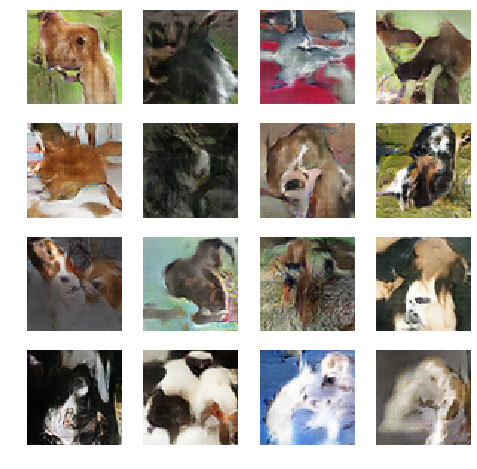

CPU times: user 6h 47min 14s, sys: 41min 55s, total: 7h 29min 10s
Wall time: 8h 29min 50s


In [21]:
%%time
print('Starting training')
train(ds, EPOCHS)
